# デモザイキング（demosaicing）のサンプル
-----

## 必要なライブラリのインポート

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt 

## PGMファイルのパース

In [2]:
def parse_pgm(fd):
    
    # 16bit pgm（バイナリ）のフォーマット例
    # P5             // P1-P6 改行(\x0A)
    # # comments
    # 4284 2844      // width スペース(\x20) height 改行(\x0A)
    # 65535          //　階調数（2^bit数-1） 改行(\x0A)
    # RGRGRGRG....
    # GBGBGBGB....   // (各色16bitずつ)

    w = 0
    h = 0
    lim = 0
    lines = 0
    count = 0
    wFlag = True
    val = np.array([])

    while True: # 改行コード（0x0A）, スペース（0x20）
        ch = fd.read(1)
        if ch==b'\x23':
            while True:
                ch = fd.read(1)
                if ch==b'\x0A':
                    break
            continue
        elif lines==1:    # 画像の縦横サイズを取得
            if ch==b'\x20' or ch==b'\x0A':
                for i in range(count):
                    if wFlag:
                        w += val[i] * pow(10, count-i-1)
                    else:
                        h += val[i] * pow(10, count-i-1)
                wFlag = False
                val = np.array([])
                count = 0
            else:
                num = int(ch)
                val = np.append(val, num)
                count = count + 1
        elif lines==2:  # センサビット深度の取得
            if ch==b'\x20' or ch==b'\x0A':
                for i in range(count):
                    lim += val[i] * pow(10, count-i-1)
            else:
                num = int(ch)
                val = np.append(val, num)
                count = count + 1
        if ch==b'\x0A':
            lines = lines + 1
        if lines>=3:
            break

    print("(w, h, lim) = ({}, {}, {})".format(w, h, lim))
    
    w = int(w)
    h = int(h)
    lim = int(lim)
    
    return w, h, lim

## 簡単なデモザイキング処理

カラーフィルタが

RGRGRG...  
GBGBGB...

という配列のRAWデータに対して，スキャン方向に最近傍の色を使用して3色のチャネルを合成（あまり賢くない処理）

In [3]:
def simple_demosaicing(img_path):
    
    # バイナリモードでオープン
    fd = open(img_path, 'rb')
    
    w, h, lim = parse_pgm(fd)
    
    # 階調が255（8ビット）よりも大きい場合は，Big endian で 16 bit ずつ読み込み
    if lim > 255:
        data = np.fromfile(fd, dtype=np.dtype('>u2'))
    else:
        data = np.fromfile(fd, dtype=np.dtype('>u1'))
    data = data.astype(float);

    img = np.zeros((h,w,3), dtype=float)
    for v in range(h-1):
        for u in range(w-1):
            i = v * w + u
            if u%2==0 and v%2==0:
                r = data[i]
                g1 = data[i+1]
                g2 = data[i+w]
                b = data[i+w+1]
            elif u%2==1 and v%2==0:
                r = data[i+1]
                g1 = data[i]
                g2 = data[i+w+1]
                b = data[i+w]
            elif u%2==0 and v%2==1:
                r = data[i+w]
                g1 = data[i+w+1]
                g2 = data[i]
                b = data[i+1]
            elif u%2==1 and v%2==1:
                r = data[i+w+1]
                g1 = data[i+w]
                g2 = data[i+1]
                b = data[i]
            img[v,u,0] = r
            img[v,u,1] = (g1+g2)/2.0
            img[v,u,2] = b
    fd.close();

    return img, w, h, lim


## 現像処理

**【注意】RAWファイルの解像度が「4284 x 2844」と大きいため環境によっては処理に時間がかかることがあります**

In [4]:
rawimg_path = "data/sample.pgm".replace('/', os.path.sep) # ファイル名

data, w, h, lim = simple_demosaicing(rawimg_path)

(w, h, lim) = (4284.0, 2844.0, 65535.0)


## matplotlib で表示

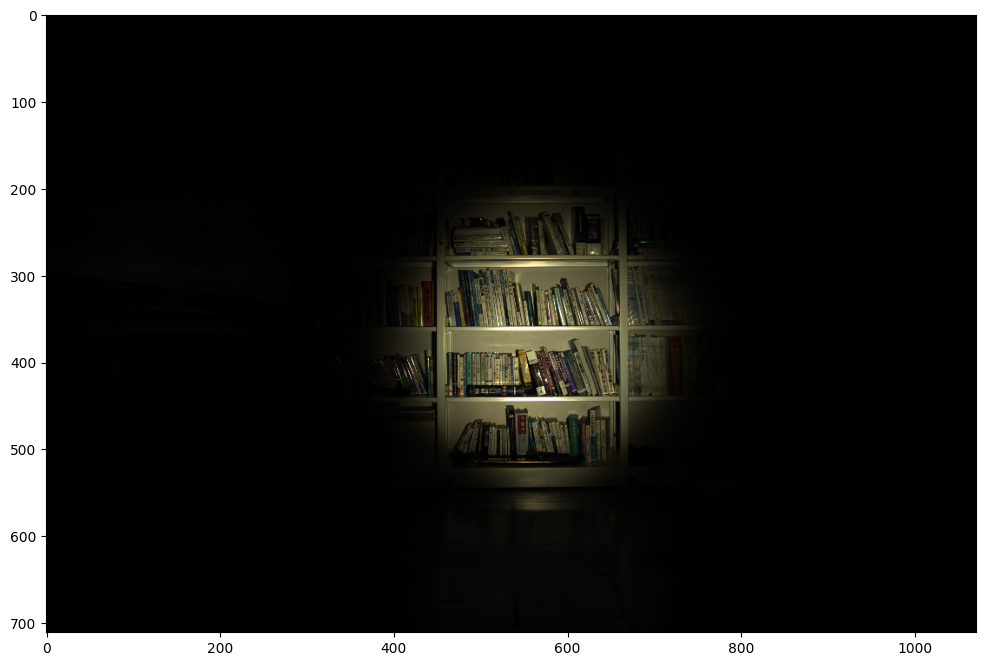

In [5]:
# ここから 8bit 画像（確認用）に変換
R = 255.0 / lim # センサビット数 -> 8bit への等倍変換
img_data = (data * R).astype(np.uint8);

img = cv2.resize(img_data, (int(w/4), int(h/4)));   # 適当な大きさにリサイズ（ここでは縦横 1/6 に縮小）

plt.figure(figsize=(12, 9))
plt.imshow(img)
plt.show()

# 画像の保存
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
out_dir = "out"
if not os.path.exists(out_dir):
    os.mkdir(out_dir)
pngimg_path = os.path.join(out_dir, "sample.png")
_ = cv2.imwrite(pngimg_path, img)